[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/color_yuv420_to_rgb.ipynb)

# Convert RGB to YUV420

### Get data and libraries to work with

In [ ]:
%%capture
!pip install kornia
!pip install py7zr

In [ ]:
%%capture
!wget http://trace.eas.asu.edu/yuv/foreman/foreman_qcif.7z

### Import needed libs

In [ ]:
import kornia
import numpy as np

# prepare the data, decompress so we have a foreman_qcif.yuv ready
import py7zr
import torch

with py7zr.SevenZipFile("foreman_qcif.7z", mode="r") as z:
    z.extractall()

### Define functions for reading the yuv file to torch tensor for use in Kornia

In [ ]:
import matplotlib.pyplot as plt


def read_frame(fname, framenum):
    # A typical 420 yuv file is 3 planes Y, u then v with u/v a quartyer the size of Y
    # Build rgb png images from foreman that is 3 plane yuv420
    yuvnp = np.fromfile(fname, dtype=np.uint8, count=int(176 * 144 * 1.5), offset=int(176 * 144 * 1.5) * framenum)
    y = torch.from_numpy(yuvnp[0 : 176 * 144].reshape((1, 1, 144, 176)).astype(np.float32) / 255.0)

    uv_tmp = yuvnp[176 * 144 : int(144 * 176 * 3 / 2)].reshape((1, 2, int(144 / 2), int(176 / 2)))
    # uv (chroma) is typically defined from -0.5 to 0.5 (or -128 to 128 for 8-bit)
    uv = torch.from_numpy(uv_tmp.astype(np.float32) / 255.0) - 0.5
    return (y, uv)

### Sample what the images look like Y, u, v channels separaatly and then converted to rgn through kornia (and back to numpy in this case)

as converted through kornia


<matplotlib.image.AxesImage>

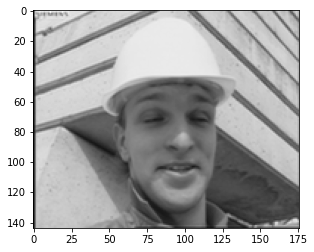

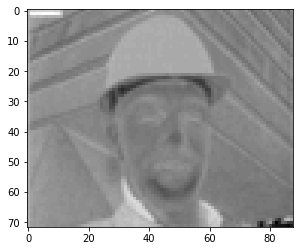

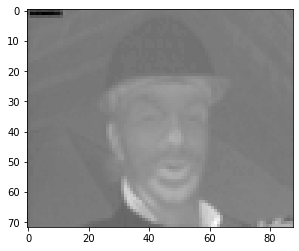

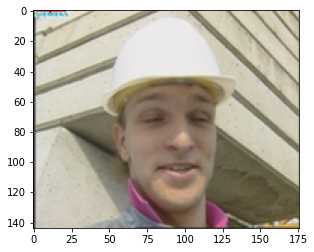

In [ ]:
(y, uv) = read_frame("foreman_qcif.yuv", 0)  # using compression classic foreman
plt.imshow((y.numpy()[0, 0, :, :] * 255.0).astype(np.uint8), cmap="gray")
plt.figure()
plt.imshow(((uv.numpy()[0, 0, :, :] + 0.5) * 255.0).astype(np.uint8), cmap="gray")
plt.figure()
plt.imshow(((uv.numpy()[0, 1, :, :] + 0.5) * 255.0).astype(np.uint8), cmap="gray")

rgb = np.moveaxis(kornia.color.yuv420_to_rgb(y, uv).numpy(), 1, 3).reshape((144, 176, 3))

print("as converted through kornia")
plt.figure()
plt.imshow((rgb * 255).astype(np.uint8))

### We can use these in some internal Kornia algorithm implementations. Lets pretend we want to do LoFTR on the red channel

/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:255: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  [i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]],
/home/edgar/software/tutorials/.venv/lib/python3.8/site-packages/kornia/feature/loftr/utils/coarse_matching.py:258: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use

<matplotlib.image.AxesImage>

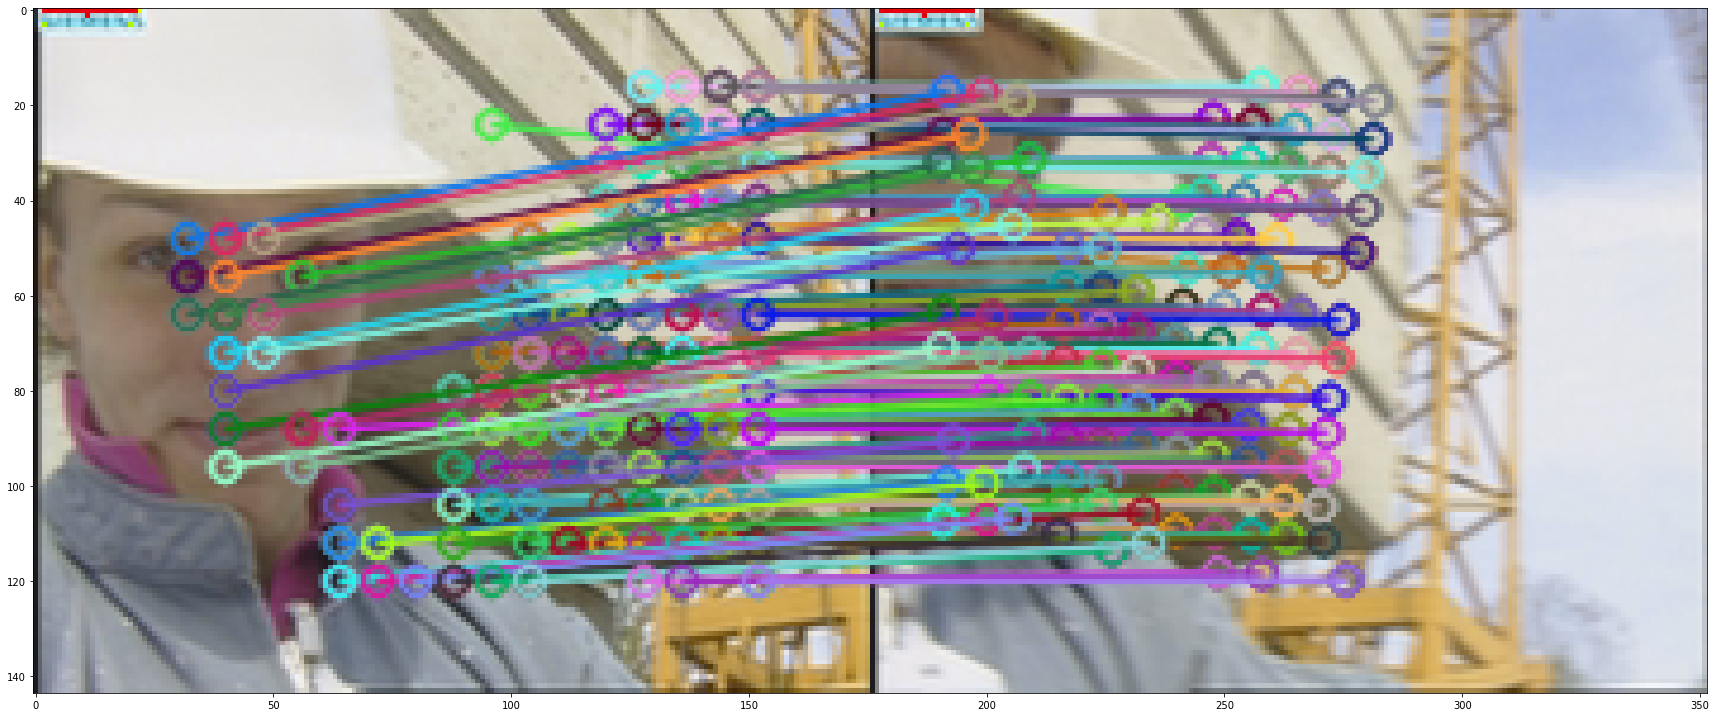

In [ ]:
import cv2

loftr = kornia.feature.LoFTR("outdoor")
(y0, uv0) = read_frame("foreman_qcif.yuv", 175)
(y1, uv1) = read_frame("foreman_qcif.yuv", 185)
rgb0 = kornia.color.yuv420_to_rgb(y0, uv0)
rgb1 = kornia.color.yuv420_to_rgb(y1, uv1)

with torch.no_grad():
    matches = loftr({"image0": rgb0[:, 0:1, :, :], "image1": rgb1[:, 0:1, :, :]})

matched_image = cv2.drawMatches(
    np.moveaxis(rgb0.numpy()[0, :, :, :] * 255.0, 0, 2).astype(np.uint8),
    [cv2.KeyPoint(x[0], x[1], 0) for x in matches["keypoints0"].numpy()],
    np.moveaxis(rgb1.numpy()[0, :, :, :] * 255.0, 0, 2).astype(np.uint8),
    [cv2.KeyPoint(x[0], x[1], 0) for x in matches["keypoints1"].numpy()],
    [cv2.DMatch(x, x, 0) for x in range(len(matches["keypoints1"].numpy()))],
    None,
)

plt.figure(figsize=(30, 30))
plt.imshow(matched_image)